# Example on how Hash (Bloom) Embedding works

This embedding has two great benefits:
1. You save a lot of storage space
2. It is possible to generate embeddings for unknown words

But how does it work?

First you have to define a static feature set, for example:
* Feature A: is a noun
* Feature B: is a verb
* Feature C: is an adjective
* Feature D: last letters are 's' or 'es'
* Feature E: has less than 5 letters

Now you have **5** Features. Each feature is initialized with a random vector that has `M` elements.
For each input-word you check what features are relevant.

Let's have a look at the word *goes*. It is a *verb* that ends in *'es'*. Also it has less
than 5 letters. Therefore features B, D and E are relevant. To generate an embedding for *goes*,
you only need to sum up the relevant vectors: 
`emb_goes = B + D + E`.

You may already see, it is important to have enough features to differentiate between many
words. A more simple approach is to generate multiple hash values for each word:

In [10]:
%matplotlib inline  

import numpy as np
import mmh3
import random
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

Let us try to generate embeddings for 20 words:

In [11]:
nouns = ['bunch', 'audience', 'flock', 'team', 'group', 'family', 
         'band', 'village', 'cat', 'sock', 'ship', 'hero',
         'monkey', 'baby', 'match', 'bed', 'dog', 'bottle', 'house',
         'paper']

len(nouns)

20

Let us also say we only want to consider 10 features (each with 2 elements).

In [12]:
num_features = 10
feature_size = 2
feature_vecs = np.random.uniform(-0.1, 0.1, (num_features, feature_size))

print(feature_vecs)

[[-0.02509198  0.09014286]
 [ 0.04639879  0.0197317 ]
 [-0.06879627 -0.0688011 ]
 [-0.08838328  0.07323523]
 [ 0.020223    0.04161452]
 [-0.0958831   0.09398197]
 [ 0.06648853 -0.05753218]
 [-0.06363501 -0.0633191 ]
 [-0.03915155  0.00495129]
 [-0.013611   -0.04175417]]


In the next step we need to define a rule on how to map a word onto multiple features.
In this example we calculate `N` hashes for each word in a range from `0` to `num_features - 1`.
This way, every word receives the same amount of hashes which can be mapped onto our feature vectors.

In this case, we choose `N = 3`

In [13]:
feature_keys_a = [mmh3.hash(n, 1) % num_features for n in nouns]
feature_keys_b = [mmh3.hash(n, 2) % num_features for n in nouns]
feature_keys_c = [mmh3.hash(n, 3) % num_features for n in nouns]

print(f'Individual features for a: {len(set(feature_keys_a))}')
print(f'Individual features for b: {len(set(feature_keys_b))}')
print(f'Individual features for c: {len(set(feature_keys_c))}')

Inividual features for a: 7
Inividual features for b: 9
Inividual features for c: 10


As you can see, one feature alone can't differentiate between every word.
There are collisions! So we combine our features:

In [14]:
feature_keys = list(zip(
    feature_keys_a,
    feature_keys_b,
    feature_keys_c,
))

print(f'Feature keys for first two inputs: {feature_keys[:2]}')
print(f'Individual combined features: {len(set(feature_keys))}')

Feature keys for first two inputs: [(3, 7, 1), (6, 0, 3)]
Individual combined features: 20


Now every word is represented by an individual tuple of keys.
Finally we can search for each word's features and sum them up:

In [15]:
embeddings = []

for (key_1, key_2, key_3) in feature_keys:
    emb = feature_vecs[key_1] + feature_vecs[key_2] + feature_vecs[key_3]
    embeddings.append(emb)

In [16]:
for word, emb in zip(nouns, embeddings):
    print(f'{word} -> {emb}')

bunch -> [-0.1056195   0.02964783]
audience -> [-0.04698673  0.10584591]
flock -> [-0.09819084 -0.0323513 ]
team -> [-0.15236199 -0.03649533]
group -> [-0.24790139  0.1038981 ]
family -> [-0.16642156 -0.12168691]
band -> [0.01700422 0.05618149]
village -> [-0.03629803 -0.11589999]
cat -> [0.02747024 0.0662975 ]
sock -> [-0.07366525  0.06295628]
ship -> [-0.07110402 -0.19513437]
hero -> [-0.2053772   0.14620977]
monkey -> [0.02450404 0.03543475]
baby -> [-0.13786759  0.1869489 ]
match -> [-0.09302958 -0.02686931]
bed -> [-0.11381896  0.11696662]
dog -> [ 0.15320006 -0.07344984]
bottle -> [-0.19606629 -0.19543929]
house -> [-0.24556283  0.07766936]
paper -> [ 0.07310053 -0.05767183]


Now each word has it's own representation, even though we only store 10 feature vectors.
However, this example has one flaw: Including unknown words is not so easy, as each word depends 
on 'random' hashes. So even if we train our features, embeddings for new words won't make any sense.

An example: 

We use this method to check if a word is a noun or verb. We may be able to train a model,
but new words receive arbitrary hash values, that won't convey relevant information...

However, training a model with known words and hash embeddings is quite easy:

In [18]:
nb_epoch = 100
learn_rate = 0.01
    
labels = np.random.uniform(-0.1, 0.1, (len(nouns), 2))
train_data = list(zip(nouns, feature_keys, labels))

losses = []

for epoch in range(nb_epoch):
    random.shuffle(train_data)
    loss=0.0

    for noun, keys, y in train_data:
        hash_vector = sum(feature_vecs[key] for key in keys)

        error = hash_vector - y

        for key in keys:
            feature_vecs[key] -= learn_rate * error

        loss += (error**2).sum()
    losses.append(loss)


Let us check if the our feature vectors were correctly updated:

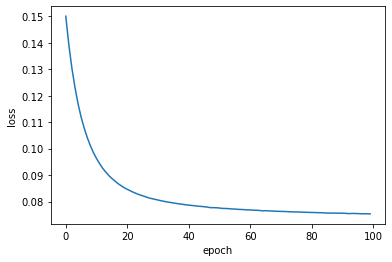

In [19]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

The loss function decreases with every epoch. So our model seems to work. Feature vectors are updated
depending on our self defined labels.